# MNIST Dataset

<br>

Datasets loaded by Scikit-Learn generally have a similar dictionary structure including:
- DESCR key describing the dataset
- A data key containing an array with one row per instance and one column per feature
- A target key containing an array with the labels

In [12]:
# download with Scikit-Learn

from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1, as_frame=False)

mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

<br>

There are 70,000 images, and each image has 784 features. This is because each image
is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black)

In [13]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


<br>

Grab an instance’s feature vector, reshape it to a 28×28 array, and display

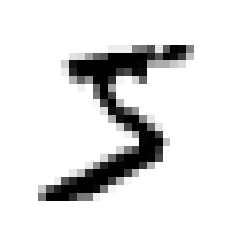

In [22]:
import matplotlib.pyplot as plt
import matplotlib as mpl

some_digit = X[0]
some_digit_img = some_digit.reshape(28,28)

plt.imshow(some_digit_img, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [24]:
# label
y[0]

'5'

<br>

label is a string. We prefer numbers, so let’s cast y to integers

In [29]:
import numpy as np
y = y.astype(np.uint8)

# note that now 5 is int
y[0]

5

<br>

create a test set and set it aside before inspecting the data
closely. <br> The MNIST dataset is actually already split into a training set (the first 60,000
images) and a test set (the last 10,000 images).

In [30]:
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

# The training set is already shuffled for us, which is good as this guarantees that all cross-validation folds will be similar.

# Training a Binary Classifier

This “5-detector” will be an example of a binary classifier, capable of
distinguishing between just two classes, 5 and not-5.  <br>
Let’s create the target vectors for this classification task

In [31]:
y_train_5 = (y_train==5)   # True for all 5s, False for all other digits
y_test_5 = (y_test==5)

<br>

Stochastic Gradient Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class. <br>
This classifier has the advantage of being capable of handling very large datasets efficiently. <br>
This is in part because SGD deals with training instances independently, one at a time
(which also makes SGD well suited for online learning)

In [32]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [33]:
# detect images of the number 5

sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

### Measuring Accuracy Using Cross-Validation

<br>

A good way to evaluate a model is to use cross-validation. <br>
Occasionally you will need more control over the cross-validation process than what
Scikit-Learn provides off-the-shelf. In these cases, you can implement crossvalidation yourself.

In [40]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=None)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    
#     counts the number of correct predictions and
#     outputs the ratio of correct predictions

    n_correct = sum(y_pred==y_test_folds)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


<br>

Let’s use the cross_val_score() function to evaluate SGDClassifier model
using K-fold cross-validation, with three folds.

In [43]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

<br>

let’s look at a very dumb classifier that just classifies every single image in the “not-5” class.

In [44]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

<br>

this model’s accuracy. <br>
That’s right, it has over 90% accuracy! This is simply because only about 10% of the
images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. <br>
This demonstrates why accuracy is generally not the preferred performance measure
for classifiers, especially when you are dealing with skewed datasets (i.e., when some
classes are much more frequent than others).

In [45]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

# Confusion Matrix


A much better way to evaluate the performance of a classifier is to look at the confusion matrix. <br>
To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to the actual targets. <br>
You could make predictions on the test set, but let’s keep it untouched and use the cross_val_predict() function
Just like the cross_val_score() function, cross_val_predict() performs K-fold
cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold.

In [47]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [48]:
# confusion matrix

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

# Precision and Recall

The confusion matrix gives you a lot of information, but sometimes you may prefer a
more concise metric. An interesting one to look at is the accuracy of the positive predictions this is called
precision of the classifier.

<br>

precision = TP/TP + FP
<br>
recall/TPR/Sensitivity: this is the ratio of positive instances that are correctly detected by the classifier
TP/TP+FN

<br>

When it claims an image represents a 5, it is correct only 83.7% of the time
Moreover, it only detects 65.1% of the 5s

In [51]:
from sklearn.metrics import precision_score, recall_score

precision_scr = precision_score(y_train_5, y_train_pred)
recall_scr = recall_score(y_train_5, y_train_pred)

print(precision_scr)
print(recall_scr)           

0.8370879772350012
0.6511713705958311


<br>
The F1 score is the harmonic mean of precision and recall. <br>
Classifier will only get a high F1 score if both recall and precision are high.

In [53]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

<br>
Scikit-Learn does not let you set the threshold directly, but it does give you access to
the decision scores that it uses to make predictions.Instead of calling the classifier’s
predict() method, you can call its decision_function() method, which returns a score for each instance

In [58]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

threshold = 0
y_some_digit_pred = (y_scores>threshold)
print(y_some_digit_pred)

# increase threshold
threshold = 8000
y_some_digit_pred = (y_scores>threshold)
print(y_some_digit_pred)

# This confirms that raising the threshold decreases recall

[ True]
[False]


<br>
Now how do you decide which threshold to use? For this you will first need to get the
scores of all instances in the training set using the cross_val_predict() function

In [59]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

<br>
Now with these scores we can compute precision and recall for all possible thresholds
using the precision_recall_curve() function

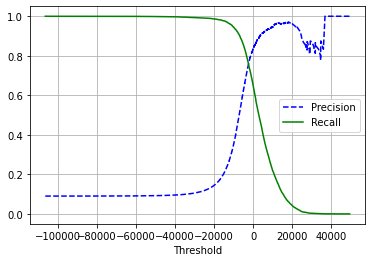

In [75]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# Finally, you can plot precision and recall as functions of the threshold value using Matplotlib

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "green", label="Recall")
    plt.legend()
    plt.xlabel("Threshold")
    plt.grid()
    
    
    
plot_precision_recall_vs_threshold(prcisions, recalls, thresholds)
plt.show()

<br>
plot precision directly against recall. <br>
precision really starts to fall sharply around 80% recall. <br>
You will probably want to select a precision/recall tradeoff just before that drop—for example,
at around 60% recall. But of course the choice depends on your project.

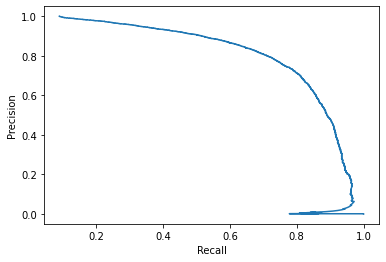

In [76]:
plt.plot(prcisions[:-1], recalls[:-1])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

<br>
So let’s suppose you decide to aim for 90% precision. You look up the first plot and
find that you need to use a threshold of about 8,000. To be more precise you can
search for the lowest threshold that gives you at least 90% precision.

In [78]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

y_train_pred_90 = (y_scores >= threshold_90_precision)

print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

# Great, you have a 90% precision classifier

0.9000345901072293
0.4799852425751706


# The ROC Curve

In [79]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

<br>

The higher the recall (TPR), the more false positives(FPR) the classifier produces. <br>
One way to compare classifiers is to measure the area under the curve (AUC). A perfect
classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

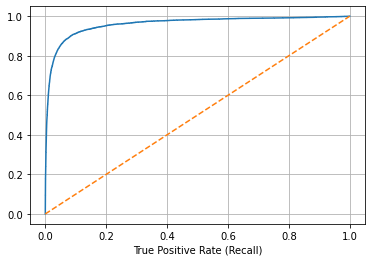

In [97]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label)
    plt.plot([0,1], [0,1], '--')
    plt.xlabel('False Positive Rate')
    plt.xlabel('True Positive Rate (Recall)')
    plt.grid()
plot_roc_curve(fpr, tpr)
plt.show()

In [112]:
# ROC AUC

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

<br>
Train a RandomForestClassifier and compare its ROC curve and ROC AUC score to the SGDClassifier. <br>
The RandomForestClassifier class does not have a decision_function() method. Instead it has a predict_proba() method.

In [88]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')


<br>
But to plot a ROC curve, you need scores, not probabilities. A simple solution is touse 
the positive class’s probability as the score.

In [113]:
y_scores_forest = y_probas_forest[:, 1]        # score = proba of positive class

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

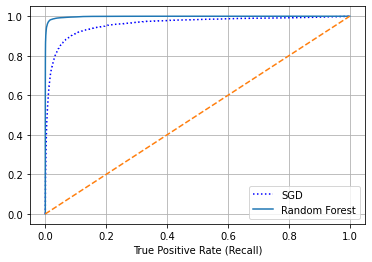

In [114]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc='lower right')
plt.show()

In [116]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

<br>

# Multiclass Classification

### one-versus-all (OvA) strategy

In [126]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

<br>
Under the hood, Scikit-Learn actually trained 10 binary classifiers(for 0 to 9 in OvA.), got their decision scores for the
image, and selected the class with the highest score.

In [127]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [128]:
np.argmax(some_digit_scores)

3

<br>
When a classifier is trained, it stores the list of target classes in its classes_ attribute

In [129]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [130]:
sgd_clf.classes_[5]

5

<br>

### One-vs-One Strategy

If you want to force ScikitLearn to use one-versus-one or one-versus-all, you can use the OneVsOneClassifier 
or OneVsRestClassifier classes. Simply create an instance and pass a binary classifier to its constructor.


In [133]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [135]:
len(ovo_clf.estimators_)

45

<br>

This time Scikit-Learn did not have to run OvA or OvO because Random Forest classifiers can directly classify instances 
into multiple classes. You can call predict_proba() to get the list of probabilities that the classifier assigned to each
instance for each class.

In [136]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [137]:
forest_clf.predict_proba([some_digit])

# the 0.9 at the 5th index in the array means that the model estimates a 90% probability that the image represents a 5.

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [139]:
# evaluate these classifiers

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [145]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

<br>

# Error Analysis

First, you can look at the confusion matrix. You need to make predictions using the
cross_val_predict() function, then call the confusion_matrix() function.

In [146]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
confusion_mx = confusion_matrix(y_train, y_train_pred)
confusion_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

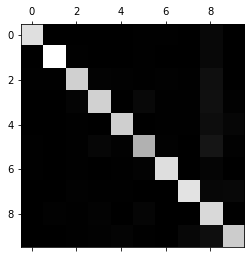

In [148]:
plt.matshow(confusion_mx, cmap=plt.cm.gray)
plt.show()

In [150]:
row_sums = confusion_mx.sum(axis=1, keepdims=True)
norm_conf_mx = confusion_mx / row_sums

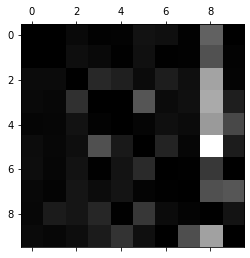

In [151]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

<br>

# Multilabel Classification

In [155]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)

y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [156]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [157]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

<br>

# Multioutput Classification

It is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have
more than two possible values) <br>

let’s build a system that removes noise from images

In [180]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [164]:
knn_clf.fit(X_train_mod, y_train_mod)

In [187]:
clean_digit = knn_clf.predict([X_test_mod[4]])

In [188]:
def plot_digit(array):
    array_image = array.reshape(28, 28)
    plt.imshow(array_image, cmap = plt.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.show()

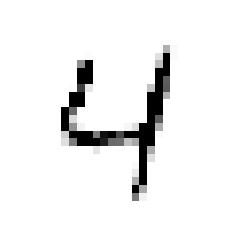

In [189]:
plot_digit(clean_digit)